<font color="#f05241"><h1>Indigo Takehome by Jennifer Philippou</h1></font>


Introduction:
    This analysis leverages 15 years of historic data to predict the 2018 corn crop yield at the county level. There are just under 1300 counties with corn yield data in the US. The problem at hand is a supervised regression problem because the objective is to predict a quantity and there are clear outcome labels. The datasets are small enough (<7 million records) to run the algorithms on a local desktop and the problem does not require additional power with techniques such as Spark or deep learning (https://towardsdatascience.com/deep-learning-specialization-by-andrew-ng-21-lessons-learned-15ffaaef627c see first image). The analysis presented here is simply a first pass MVP done over the weekend with many areas for improvement from both a technical and a contextual perspective.

## Table of Contents
<a href='#section1'>1. Data preparation and cleansing</a>

<a href='#section2'>2. Exploratory analysis and feature building</a>

<a href='#section3'>3. Construction of predictive models</a>

<a href='#section4'>4. Evaluation of predictive models</a>

<a href='#section5'>5. Presenting your results</a>

<a id='section1'></a>
## Section 1 - Data preparation and cleansing

Here I am loading standard libraries and taking a peak at each of the three data files with the 'head' command. The 'shape' command details the number of rows and columns in the dataframe. Comparing the 3 tables, it is clear that the data is presented at different grains and requires manipulation. For an MVP model, I have taken the daily observations table and summarized the rows into a single entry for each year (collapsing the date column). 

I am also looking for extreme values with the 'describe' command which shows both the min and max value for each column, but I do not see obvious outliers; however this could be confirmed by plotting the cook's distance. The daily observations and common data both run from 2003 to 2018, but the annual yield goes all the way back to 1990.

There are no categorical variables, only numeric ones, which makes an MVP model easier to build, but there is more opportunity for feature engineering. 

Temperatures measures appear to be in Kelvin, not Fahrenheit or Celsius, which can be converted to F with (K − 273.15) × 9/5 + 32 to make interpretation easier. Some of the variables, such as the MODIS band measures are on a scale from 0 to 1 and for some types of models this could bias the model to weight those features as lower importance. The work around for this would be to normalize all of the features, but performing this step is also a detriment to model interpretability (eg with a LR model the features would use their unit of measure). The best approach usually depends on if you want an explanatory model or a predictive one, but if you have time, it’s nice to run the model both ways and see what sort of performance boost is achieved.


### Environment setup
I am running python 3.6.4 with an Anaconda install on my windows 10 pc

In [61]:
##Some Standard Libraries
#Data Manipulation
import pandas as pd
import numpy as np
from datetime import timedelta

#modeling functions
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
#new
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.grid_search import GridSearchCV
#model accuracy/tools
import time #to track/compare runtime
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm

# database
import psycopg2 
import json

#visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import ProbPlot
%matplotlib inline

### First peek at the data

In [2]:
df_common_data = pd.read_csv('data/common_data.csv')
df_common_data.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2
0,US01031,US01,2003,123.0,5500.0,72,295,0.805210,99.040770
1,US01031,US01,2004,111.0,6900.0,72,295,0.907701,100.754813
2,US01031,US01,2005,127.0,6000.0,72,295,0.837486,106.360702
3,US01031,US01,2006,85.0,5600.0,72,295,0.844281,71.763873
4,US01031,US01,2007,73.0,8300.0,72,295,0.853341,62.293884


In [3]:
df_common_data.shape

(19134, 9)

In [4]:
df_common_data.describe()

,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2
count,19134.000000,17842.000000,17842.000000,19134.000000,19134.000000,19134.000000,19134.000000
mean,2010.403366,143.677267,63626.218473,109.769572,291.260845,0.888676,118.971934
std,4.622965,36.093977,58553.730991,23.705447,15.442627,0.079734,48.078793
min,2003.000000,10.400000,5050.000000,47.000000,226.000000,0.697055,0.000000
25%,2006.000000,122.000000,18200.000000,91.000000,282.000000,0.837486,96.438760
50%,2010.000000,147.400000,44000.000000,111.000000,289.000000,0.868063,125.262741
75%,2014.000000,169.900000,91100.000000,128.000000,299.000000,0.953567,151.205662
max,2018.000000,255.400000,394000.000000,156.000000,337.000000,1.000000,252.507588


In [5]:
len(df_common_data['adm2_code'].unique()) # number of counties in the analysis

1297

In [6]:
df_annual_yields = pd.read_csv('data/annual_yields.csv')
df_annual_yields.head()
#I added an index to base the figures off of the 1990 values or the 2017 values, 
#I decided to go with index2 because its a more conservative yield

,year,yield,index,index2
0,1990,118.5,1.000000,0.671008
1,1991,108.6,0.916456,0.614949
2,1992,131.5,1.109705,0.744621
3,1993,100.7,0.849789,0.570215
4,1994,138.6,1.169620,0.784824


In [7]:
df_annual_yields.shape

(28, 4)

In [8]:
df_annual_yields.describe()

,year,yield,index,index2
count,28.000000,28.000000,28.000000,28.000000
mean,2003.500000,142.032143,1.198583,0.804259
std,8.225975,19.967901,0.168505,0.113069
min,1990.000000,100.700000,0.849789,0.570215
25%,1996.750000,128.750000,1.086498,0.729049
50%,2003.500000,140.400000,1.184810,0.795017
75%,2010.250000,154.500000,1.303797,0.874858
max,2017.000000,176.600000,1.490295,1.000000


In [9]:
df_daily_observations = pd.read_csv('data/daily_observations.csv')
df_daily_observations.head()

,adm2_code,year,date,doy,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
0,US01031,2003,2003-01-01,1,287.44855,0,0,0,4.298554,96.77753,...,288.11395,273.58743,0.08692,0.244635,0.03991,0.07201,0.30011,0.259010,0.162760,0.475683
1,US01031,2003,2003-01-02,2,286.61816,0,0,0,5.022919,87.06785,...,288.11395,273.58743,0.08596,0.245240,0.04046,0.07342,0.29704,0.259070,0.159570,0.480918
2,US01031,2003,2003-01-03,3,277.10223,1,0,0,0.000000,88.82168,...,288.11395,273.58743,0.08415,0.245300,0.03945,0.07473,0.29792,0.257964,0.154409,0.489149
3,US01031,2003,2003-01-04,4,276.73196,1,0,0,0.399628,80.37215,...,288.11395,273.58743,0.08143,0.247400,0.03815,0.07355,0.29815,0.257130,0.156588,0.504729
4,US01031,2003,2003-01-05,5,281.21307,1,0,0,3.454437,76.90567,...,288.11395,273.58743,0.08141,0.245780,0.03817,0.07355,0.29834,0.261379,0.157310,0.502369


In [10]:
df_daily_observations.shape

(6983910, 28)

In [11]:
df_daily_observations.describe().apply(lambda x: round(x,2))

,year,doy,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_vpd,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
count,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,...,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00,6983910.00
mean,2010.40,183.00,285.01,0.32,0.03,0.17,6.06,88.20,290.98,0.30,...,293.05,277.91,0.16,0.32,0.11,0.14,0.32,0.26,0.16,0.43
std,4.62,105.37,10.97,0.47,0.18,0.37,5.60,12.43,11.94,0.44,...,12.83,10.70,0.18,0.14,0.18,0.18,0.05,0.07,0.07,0.23
min,2003.00,1.00,260.00,0.00,0.00,0.00,0.00,15.00,260.00,0.00,...,243.84,236.01,0.02,0.09,0.01,0.03,0.06,0.01,0.01,-0.58
25%,2006.00,92.00,276.49,0.00,0.00,0.00,0.00,81.07,281.90,0.01,...,284.44,270.32,0.08,0.23,0.04,0.07,0.29,0.22,0.11,0.28
50%,2010.00,183.00,286.21,0.00,0.00,0.00,5.02,91.46,292.96,0.15,...,296.80,278.55,0.10,0.29,0.05,0.09,0.33,0.26,0.16,0.40
75%,2014.00,274.00,294.29,1.00,0.00,0.00,11.07,99.63,300.83,0.42,...,302.64,287.04,0.13,0.38,0.06,0.10,0.36,0.30,0.20,0.60
max,2018.00,365.00,311.44,1.00,1.00,1.00,20.00,100.00,320.00,7.75,...,326.46,300.80,0.94,0.89,0.93,0.94,0.53,0.48,0.42,0.91


In [12]:
len(df_daily_observations['adm2_code'].unique())

1297

### Missing Values

All 3 data files appear to be very complete.

In [13]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

In [14]:
get_percentage_missing(df_common_data)

adm2_code             0.00
adm1_code             0.00
year                  0.00
yield                 0.07
area_harvested_obs    0.07
phen_gup              0.00
phen_dor              0.00
index2                0.00
yield_modified2       0.00
dtype: float64

In [15]:
df_common_data.iloc[21:26,2:5]

,year,yield,area_harvested_obs
21,2015,159.1,20200.0
22,2016,126.2,23300.0
23,2017,195.3,15000.0
24,2018,NaN,NaN
25,2003,100.0,12000.0


In [16]:
df_common_data[df_common_data['yield'].isna()].head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2
9,US01031,US01,2018,NaN,NaN,72,295,1.0,0.0
24,US01033,US01,2018,NaN,NaN,84,281,1.0,0.0
40,US01049,US01,2018,NaN,NaN,73,299,1.0,0.0
56,US01071,US01,2018,NaN,NaN,77,292,1.0,0.0
72,US01077,US01,2018,NaN,NaN,78,284,1.0,0.0


In [17]:
#shows NAs don't occur outside of 2018
df_common_data[(df_common_data['year']!=2018) & (df_common_data['yield'].isna())]

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2


In [18]:
get_percentage_missing(df_annual_yields)

year      0.0
yield     0.0
index     0.0
index2    0.0
dtype: float64

In [19]:
get_percentage_missing(df_daily_observations)

adm2_code           0.0
year                0.0
date                0.0
doy                 0.0
met_avg_t           0.0
met_extreme_cold    0.0
met_extreme_hot1    0.0
met_extreme_hot2    0.0
met_gdd             0.0
met_max_rh          0.0
met_max_t           0.0
met_max_vpd         0.0
met_min_rh          0.0
met_min_t           0.0
met_p_mm            0.0
met_sh              0.0
met_sr_wm2          0.0
mod_evi             0.0
mod_lst_day         0.0
mod_lst_night       0.0
mod_nbar_1          0.0
mod_nbar_2          0.0
mod_nbar_3          0.0
mod_nbar_4          0.0
mod_nbar_5          0.0
mod_nbar_6          0.0
mod_nbar_7          0.0
mod_ndvi            0.0
dtype: float64

### Data Distributions

Many of the variables have a wide distribution which will help with predictions. Applying non-linear transformations such as squaring the figures or taking a log of the figures to reshape the distributions closer to normal is less applicable with this data set--only a few variables are crying out for modification such as the max-vpd, evi, mode-nbar1, 3 and 4. With more time, I would test the impact of these types of transformations to see how much lift they provide to the model.

Looking at the distributions also shows where an indicator variable may be helpful. For example, here I might consider creating a flag for counties with 0 days temperature in the 'Count of growing degree days'. I haven't actually followed through with this because I am very skeptical of this variable meaning--In a table of daily observations there shouldn't be a count of days above 1, but the histogram shows the values exceed 15. If the distribution is bi or tri-modal that could be a good sign to create categorical variables. The distributions also provide insight where good break points for custom bins may fall.

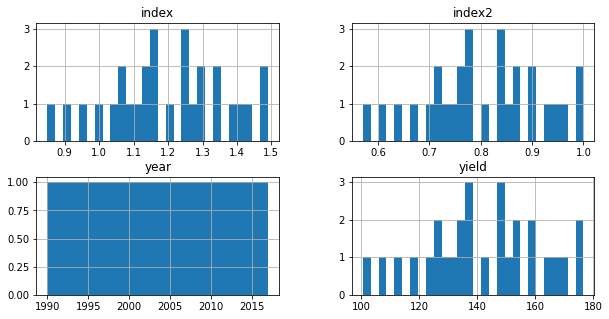

In [20]:
df_annual_yields.hist(figsize=(10,5), bins=28)
plt.show()

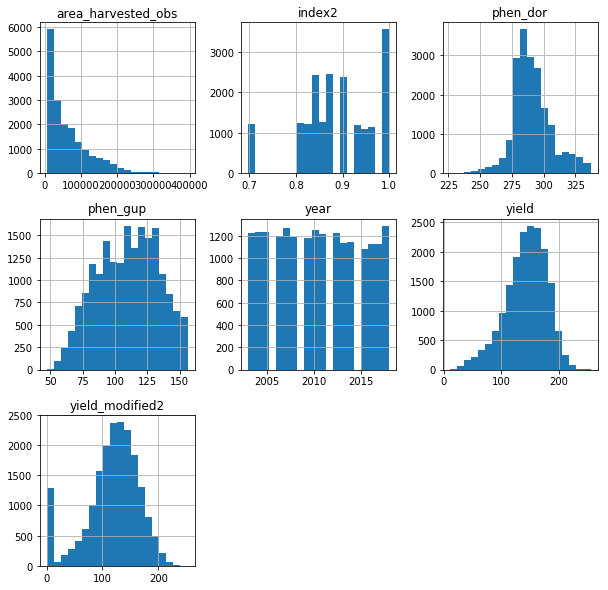

In [22]:
# histograms for each feature
df_common_data.hist(figsize=(10,10), bins=20)
plt.show()

It might be interesting to get an average harvest area for a bayesian model... The 0's on the yield modified are for 2018

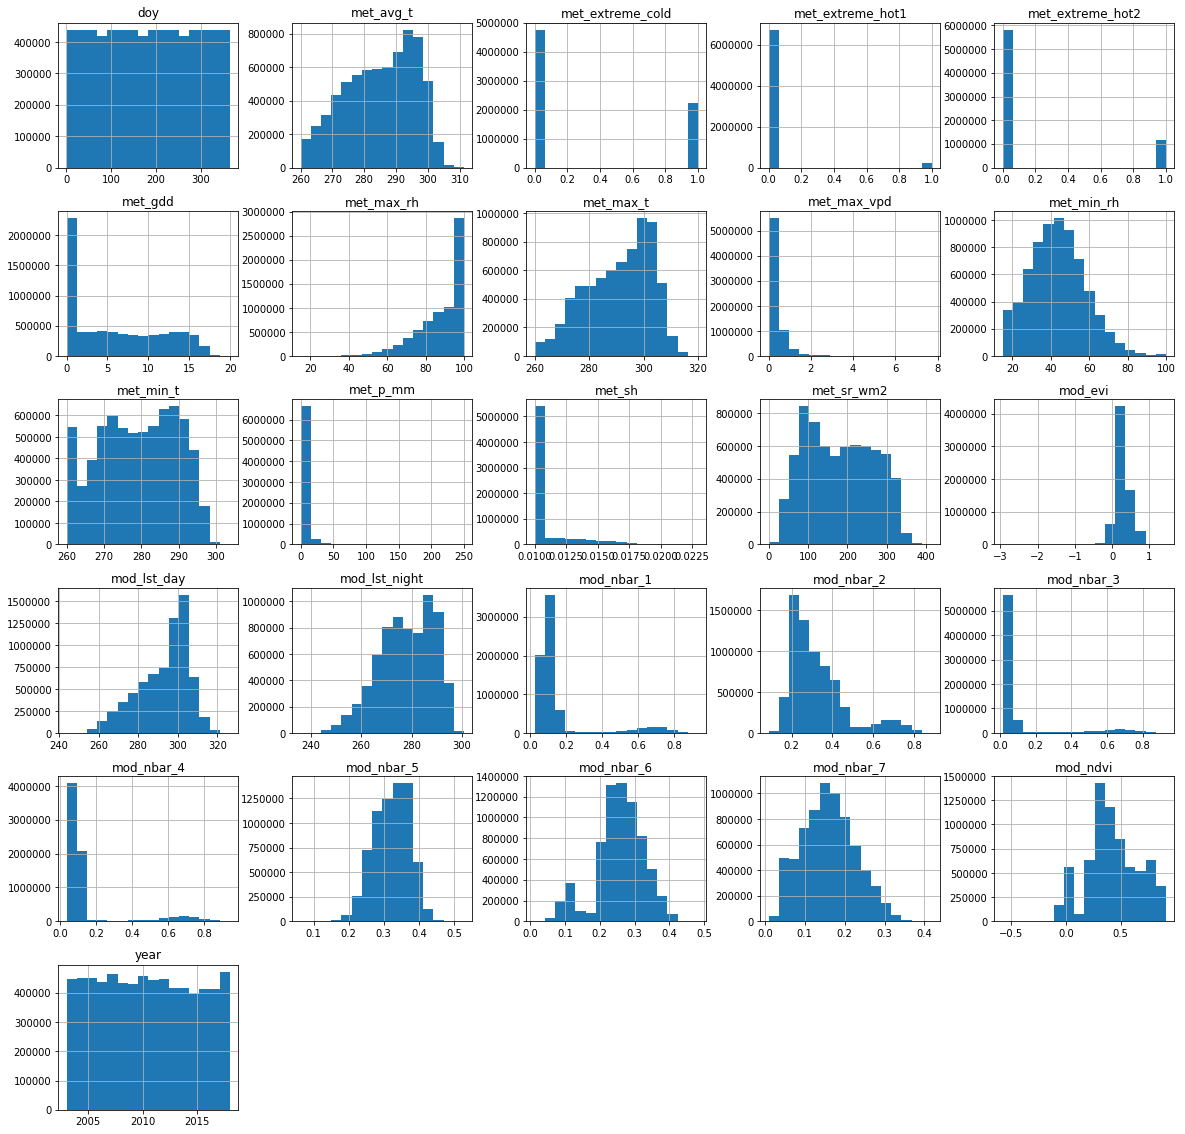

In [23]:
# histograms for each feature
df_daily_observations.hist(figsize=(20,20), bins=16)
plt.show()

### Preliminary Joining of datasets

I want to make some quick and dirty regression plots for each variable, but I need the outcome values tied to the daily observations. I hope these plots will help me focus my feature engineering on variables that have some association with the outcome.

In [24]:
year_distribution = pd.DataFrame(df_daily_observations.groupby('year').count()['adm2_code'])
year_distribution[1:2]

,adm2_code
year,
2004,449315


In [25]:
year_distribution.index

Int64Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='year')

Text(0.5,1,'Distribution of Daily Observation Count By Year')

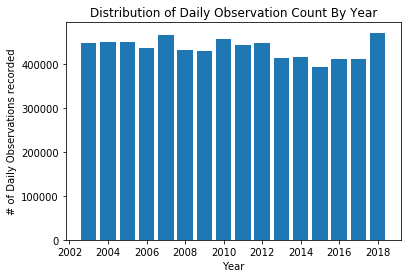

In [26]:
#Not every year generates the same number of observations, potentially introducing bias into the model, but I did expect the distribution to have more variation
#the number of counties grows over time and this implies the data collection quality might have dipped after 2012
plt.bar(year_distribution.index,  year_distribution['adm2_code'])
plt.xlabel('Year')
plt.ylabel("# of Daily Observations recorded")
plt.title("Distribution of Daily Observation Count By Year")

In [27]:
df_03to17_all = pd.merge(df_common_data, df_daily_observations, on=['adm2_code','year'], how = 'outer')
df_03to17_all.tail()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2,date,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
6983905,US56021,US56,2018,NaN,NaN,107,298,1.0,0.0,2018-12-27,...,277.18744,263.32153,0.217743,0.298552,0.148802,0.182946,0.323986,0.284256,0.205203,0.156517
6983906,US56021,US56,2018,NaN,NaN,107,298,1.0,0.0,2018-12-28,...,277.18744,263.32153,0.267442,0.336201,0.203244,0.235959,0.327380,0.278578,0.177720,0.113907
6983907,US56021,US56,2018,NaN,NaN,107,298,1.0,0.0,2018-12-29,...,277.18744,263.32153,0.262515,0.332445,0.189960,0.226690,0.333914,0.290455,0.194634,0.117537
6983908,US56021,US56,2018,NaN,NaN,107,298,1.0,0.0,2018-12-30,...,277.18744,263.32153,0.256925,0.329420,0.183845,0.220745,0.338850,0.292329,0.191880,0.123639
6983909,US56021,US56,2018,NaN,NaN,107,298,1.0,0.0,2018-12-31,...,277.18744,263.32153,0.262956,0.335371,0.197159,0.231143,0.339737,0.290971,0.185796,0.121030


In [28]:
df_03to17_all.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,index2,yield_modified2,date,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
0,US01031,US01,2003,123.0,5500.0,72,295,0.80521,99.04077,2003-01-01,...,288.11395,273.58743,0.08692,0.244635,0.03991,0.07201,0.30011,0.259010,0.162760,0.475683
1,US01031,US01,2003,123.0,5500.0,72,295,0.80521,99.04077,2003-01-02,...,288.11395,273.58743,0.08596,0.245240,0.04046,0.07342,0.29704,0.259070,0.159570,0.480918
2,US01031,US01,2003,123.0,5500.0,72,295,0.80521,99.04077,2003-01-03,...,288.11395,273.58743,0.08415,0.245300,0.03945,0.07473,0.29792,0.257964,0.154409,0.489149
3,US01031,US01,2003,123.0,5500.0,72,295,0.80521,99.04077,2003-01-04,...,288.11395,273.58743,0.08143,0.247400,0.03815,0.07355,0.29815,0.257130,0.156588,0.504729
4,US01031,US01,2003,123.0,5500.0,72,295,0.80521,99.04077,2003-01-05,...,288.11395,273.58743,0.08141,0.245780,0.03817,0.07355,0.29834,0.261379,0.157310,0.502369


In [29]:
df_03to17_all.shape

(6983910, 35)

In [30]:
sample = df_03to17_all.sample(1000)

In [31]:
sample.shape

(1000, 35)

<a id='section2'></a>
## Section 2 - Exploratory analysis & feature building

What features look like they might be more predictive? How does the sample compare to the larger dataset?

While this is only a sample, some general trends can be taken from it. It appears the greenup date is very informative--the later greenup dates are associated with higher annual yields. The dormancy date is less disbursed and seems to have a less clear trend. The extreme hot and cold indicators and the average temperature are not showing much. The meterology variables (max and min humidity) also seem less helpful. The last day and night's temperature  & modis band 6 and 7 appear to have a slightly negative correlation while the MODIS band 1-5 have slightly positive relationships.

Observed precipitation seems to have a less clear relationship than I would have expected. I would definitley want to take a non-linear transformation on this variable because the figures are a little clustered together. Its also super surprising/odd that the amount of rain isn't showing more influence. An indicator for rain would probably be a great idea.

With more time I would want to dive into why the ndvi graph (lower right quadrant in aquamarine) is only showing 1 point when the missing analysis showed the dataset is very complete.

In [33]:
FIELDS = list(df_03to17_all.columns.values)
FIELDS

['adm2_code',
 'adm1_code',
 'year',
 'yield',
 'area_harvested_obs',
 'phen_gup',
 'phen_dor',
 'index2',
 'yield_modified2',
 'date',
 'doy',
 'met_avg_t',
 'met_extreme_cold',
 'met_extreme_hot1',
 'met_extreme_hot2',
 'met_gdd',
 'met_max_rh',
 'met_max_t',
 'met_max_vpd',
 'met_min_rh',
 'met_min_t',
 'met_p_mm',
 'met_sh',
 'met_sr_wm2',
 'mod_evi',
 'mod_lst_day',
 'mod_lst_night',
 'mod_nbar_1',
 'mod_nbar_2',
 'mod_nbar_3',
 'mod_nbar_4',
 'mod_nbar_5',
 'mod_nbar_6',
 'mod_nbar_7',
 'mod_ndvi']

In [34]:
FIELDS = list(df_03to17_all.columns.values)
FIELDS.remove('date')
FIELDS.remove('yield_modified2')
FIELDS.remove('index2')
FIELDS = FIELDS[2:]
len(FIELDS)

32

Text(0.5,0.9,'Individual Features vs. Outcome (yield)')

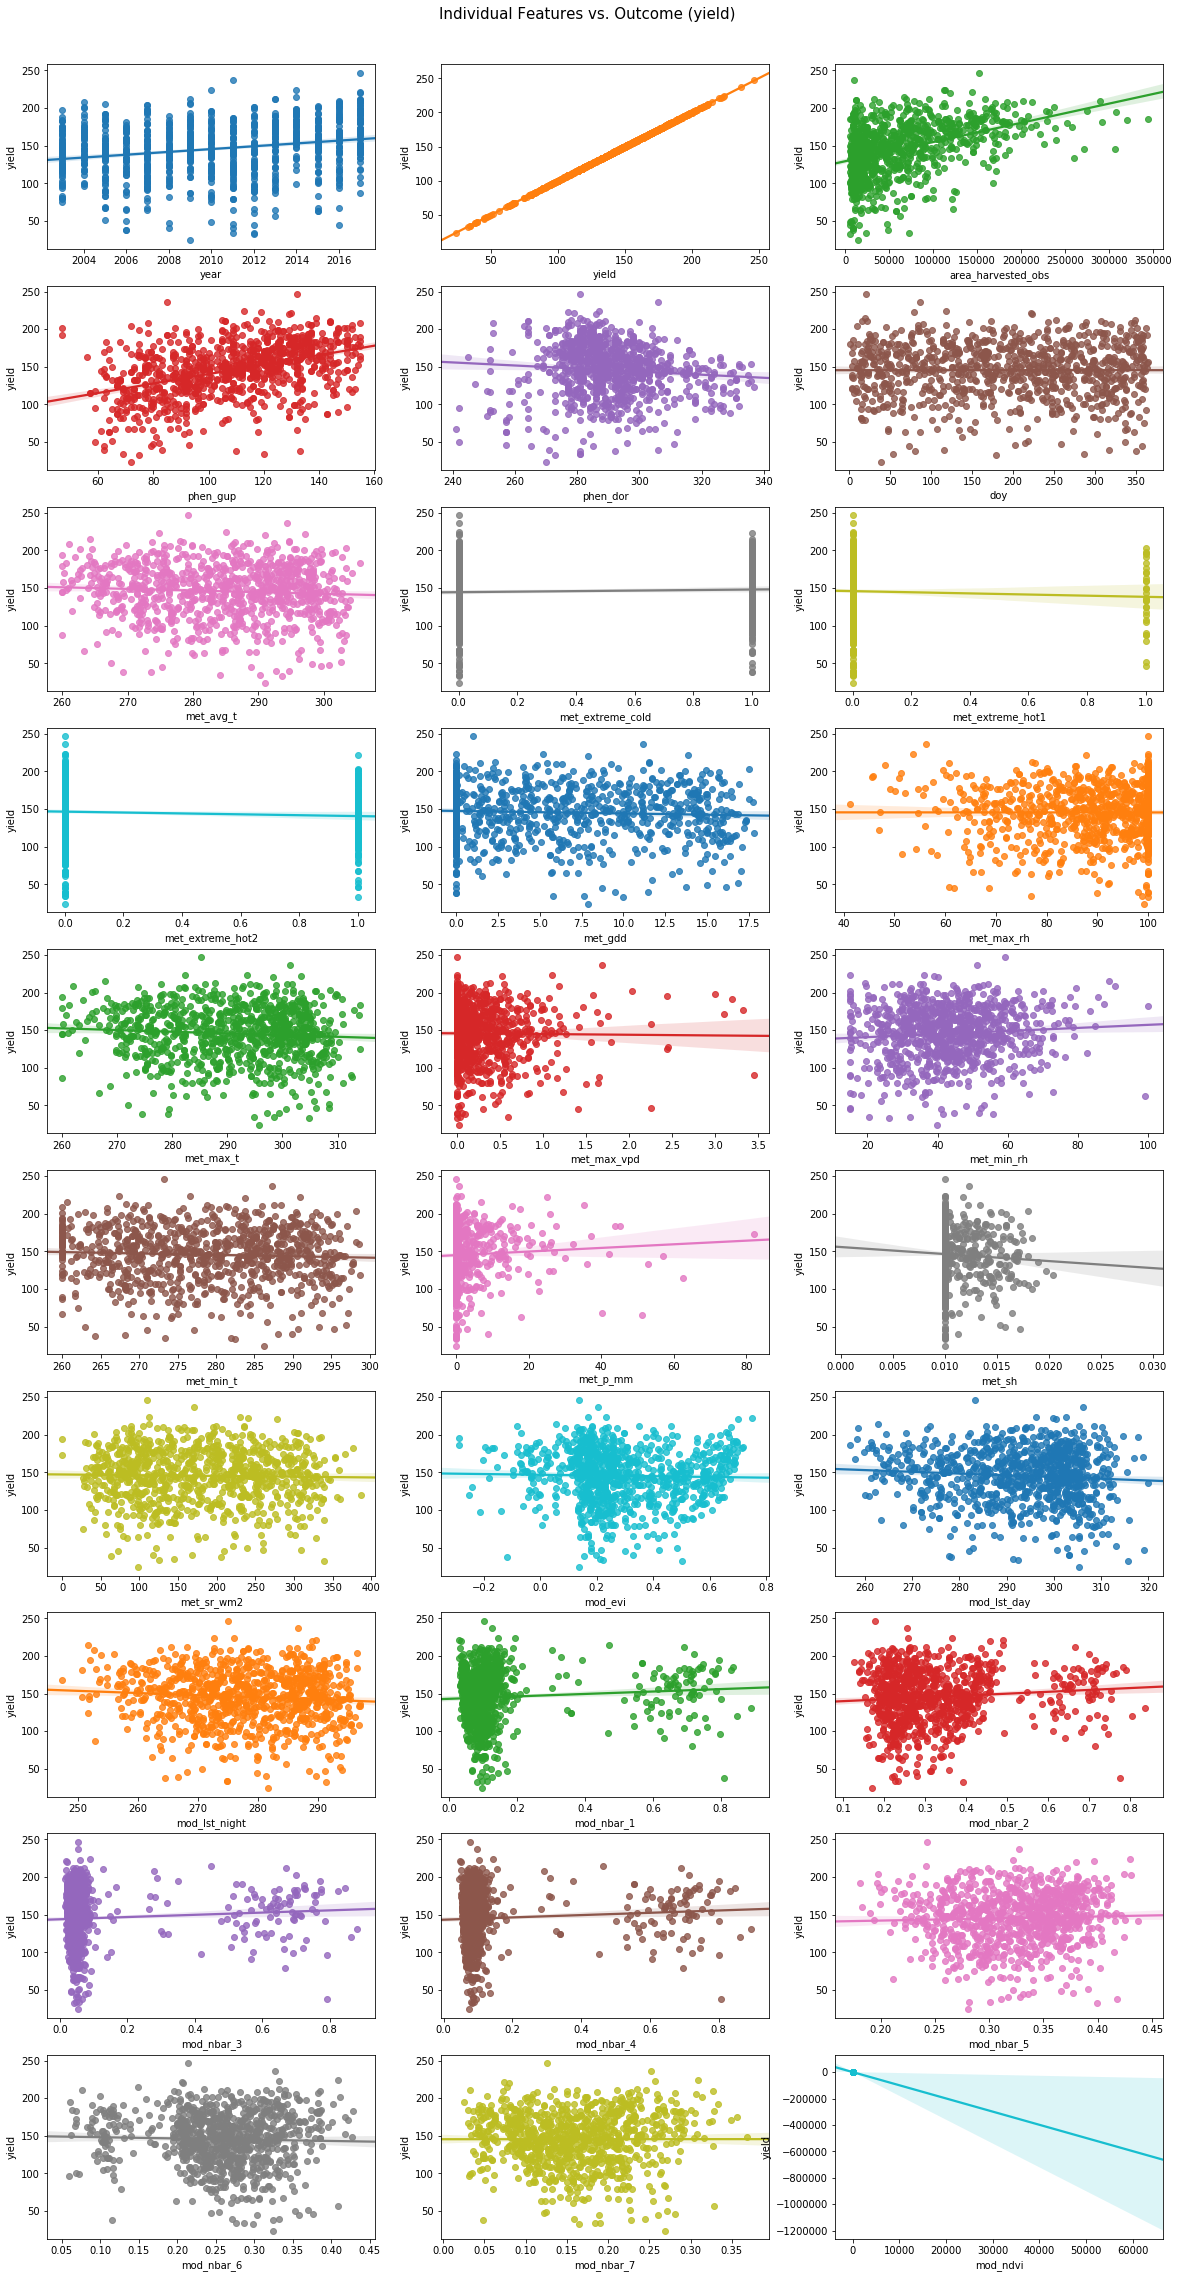

In [39]:
fig, ax_grid = plt.subplots(10, 3, figsize=(20,40))
for idx, feature in enumerate(FIELDS[:]):
    sns.regplot(x=sample[feature], y=sample["yield"], ax=ax_grid[idx//3][idx%3])
    ax_grid[idx//3][idx%3]
fig.suptitle("Individual Features vs. Outcome (yield)", fontsize=15, y=0.9)

### Variables to focus on when creating annual features: green up date, last night/day, MODIS variables.

The correlation plots highlight the high degree of overlap among several of the variables. If a regression model proves to have the strongest predictive power, it would be prudent to double check this graph to avoid multi-collinearity. This vis. can also be used to compare the sample with with entire dataset to look for any strong differences between the 2 (helps validate trends seen in the scatterplots above and quantifies the slope of the regression line in a way that facilitates cross comparison of variables)

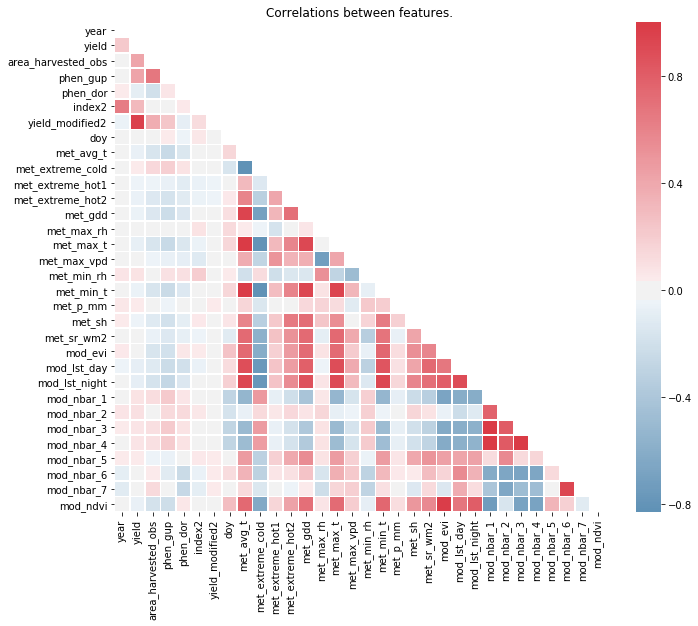

In [40]:
# plot heatmap for correlations matrix 
corr = sample.corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

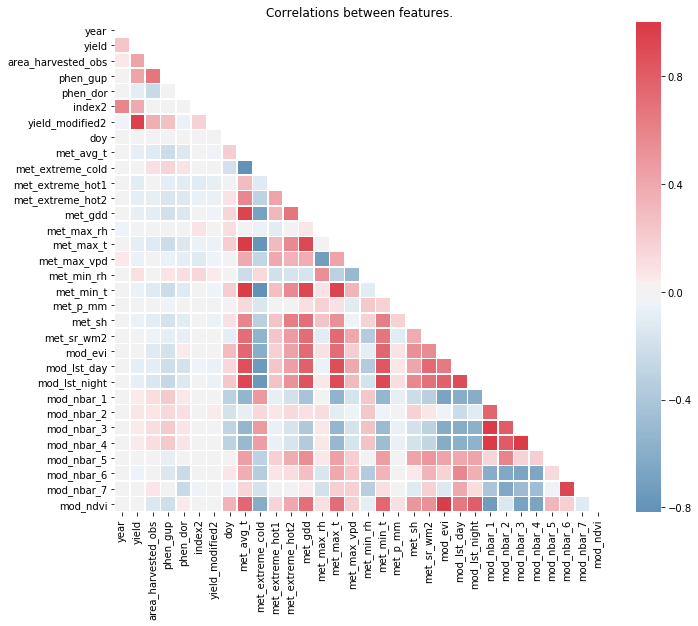

In [41]:
# plot heatmap for correlations matrix 
corr = df_03to17_all.corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

## Creating an annual dataset

In [45]:
#note I have a configuration file
with open('database/config.json') as f:
    conf = json.load(f)
conf

{'database': 'postgres',
 'host': 'localhost',
 'passw': '1234',
 'port': '5432',
 'user': 'postgres'}

In [46]:
conn_str = "host={} dbname={} user={} password={} ".format(conf['host'], conf['database'], conf['user'], conf['passw'])
conn = psycopg2.connect(conn_str)

Here are a few examples of the backend Postgresql components:

![Postgresql1](img/load_daily_obs_query.jpg)

![Postgresql2](img/annual_query.jpg)

Initially I thought I would have more time to create more sophisticated features that lend well to sql (such as the total change in temp from one day to the next over the entire growing season for each county). Unfortunately I spent the time tinkering with monthly calcs and some other items.

In [47]:
df_annual_observations= pd.read_sql('select * from public.annual_observations2', con=conn)
df_annual_observations.head()

,adm2_code,year,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,...,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,rainy_days,total_grow_days,yield,area_harvested_obs,yield_modified2
0,US01031,2003.0,76.754107,1,0,105,12.717066,100.0,95.432,97.273174,...,0.091597,0.383032,0.294719,0.167882,0.582226,143,223.0,123.0,5500.0,99.040770
1,US01031,2004.0,76.617500,2,3,112,12.648949,100.0,100.922,96.080696,...,0.092265,0.381888,0.305693,0.178722,0.567168,129,223.0,111.0,6900.0,100.754813
2,US01031,2005.0,77.131786,0,1,129,12.750473,100.0,98.600,95.952787,...,0.090145,0.380605,0.293601,0.166506,0.585358,129,223.0,127.0,6000.0,106.360702
3,US01031,2006.0,77.991607,2,37,153,12.718925,100.0,102.812,95.164162,...,0.099908,0.386895,0.314021,0.202066,0.535076,121,223.0,85.0,5600.0,71.763873
4,US01031,2007.0,78.497857,2,29,149,13.105056,100.0,105.242,92.990486,...,0.093294,0.383400,0.306551,0.186277,0.553988,108,223.0,73.0,8300.0,62.293884


In [51]:
df_03to17_annual = df_annual_observations
#pd.merge(df_common_data, df_annual_observations, on=['adm2_code','year'], how = 'outer') #now this is done in sql
df_03to17_annual.tail()

,adm2_code,year,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,...,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,rainy_days,total_grow_days,yield,area_harvested_obs,yield_modified2
19129,US56021,2013.0,64.251875,32,4,63,7.719892,100.0,101.264,79.219189,...,0.110819,0.345090,0.323698,0.233083,0.415575,114,191.0,92.3,13000.0,82.630974
19130,US56021,2014.0,63.455000,18,2,37,7.230178,100.0,100.832,87.327037,...,0.105221,0.342730,0.303397,0.206701,0.447882,99,191.0,117.6,10500.0,113.870895
19131,US56021,2015.0,63.848750,11,0,43,7.147995,100.0,98.276,89.019720,...,0.110308,0.343112,0.300128,0.197056,0.445085,113,191.0,144.9,10400.0,138.171914
19132,US56021,2016.0,63.483125,25,4,56,7.423966,100.0,101.804,83.720941,...,0.104559,0.352307,0.319507,0.214062,0.436938,99,191.0,113.8,15200.0,112.511212
19133,US56021,2018.0,63.014375,23,0,32,7.021319,100.0,97.718,87.071615,...,0.105909,0.350297,0.316863,0.218047,0.435656,109,191.0,NaN,NaN,0.000000


Some light QC on the data join

In [52]:
df_03to17_annual.shape

(19134, 35)

In [53]:
list(df_03to17_annual.columns.values)

['adm2_code',
 'year',
 'met_avg_t',
 'met_extreme_cold',
 'met_extreme_hot1',
 'met_extreme_hot2',
 'met_gdd',
 'met_max_rh',
 'met_max_t',
 'met_max_avg_rh',
 'met_max_avg_t',
 'met_max_vpd',
 'met_min_rh',
 'met_min_t',
 'met_min_avg_rh',
 'met_min_avg_t',
 'met_p_mm',
 'met_sh',
 'met_sr_wm2',
 'met_evi',
 'mod_lst_day',
 'mod_lst_night',
 'mod_nbar_1',
 'mod_nbar_2',
 'mod_nbar_3',
 'mod_nbar_4',
 'mod_nbar_5',
 'mod_nbar_6',
 'mod_nbar_7',
 'mod_ndvi',
 'rainy_days',
 'total_grow_days',
 'yield',
 'area_harvested_obs',
 'yield_modified2']

<a id='section3'></a>
## Section 3 - Construction of predictive models

In [59]:
#remove 2018 data because that's the validation set (I don't have actuals yet so that data can't be used to assess the model accuracy, 
# but I can make preliminary predictions and graphs for it)
data_validation = df_03to17_annual[df_03to17_annual['year']==2018]
data_validation = data_validation.drop('yield', axis = 1)
data_validation = data_validation.drop('yield_modified2', axis = 1)
data_validation = data_validation.drop('area_harvested_obs', axis = 1)
data_validation = data_validation.drop('adm2_code', axis = 1)
data_validation = data_validation.drop('year', axis = 1)
#data_validation = data_validation.drop('adm1_code', axis = 1)

#spliting into data and lbales
data = df_03to17_annual[df_03to17_annual['year']!=2018]
labels = data.values[:, -3]
data = data.drop('yield', axis = 1)
data = data.drop('yield_modified2', axis = 1)
data = data.drop('area_harvested_obs', axis = 1)
data = data.drop('year', axis = 1)
#data.drop('date', axis = 1)
data = data.drop('adm2_code', axis = 1)
#data = data.drop('adm1_code', axis = 1)

data.reset_index()
#data.as_matrix().astype(np.float)
#labels.as_matrix().astype(np.float)

#splitting into train and test
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.25, random_state=2)
print("train data shape: ", data_train.shape)
print("test data shape: ", data_test.shape)
print("train labels shape: ", labels_train.shape)
print("test labels shape: ", labels_test.shape)

train data shape:  (13381, 30)
test data shape:  (4461, 30)
train labels shape:  (13381,)
test labels shape:  (4461,)


In [57]:
get_percentage_missing(data)

year                0.0
met_avg_t           0.0
met_extreme_cold    0.0
met_extreme_hot1    0.0
met_extreme_hot2    0.0
met_gdd             0.0
met_max_rh          0.0
met_max_t           0.0
met_max_avg_rh      0.0
met_max_avg_t       0.0
met_max_vpd         0.0
met_min_rh          0.0
met_min_t           0.0
met_min_avg_rh      0.0
met_min_avg_t       0.0
met_p_mm            0.0
met_sh              0.0
met_sr_wm2          0.0
met_evi             0.0
mod_lst_day         0.0
mod_lst_night       0.0
mod_nbar_1          0.0
mod_nbar_2          0.0
mod_nbar_3          0.0
mod_nbar_4          0.0
mod_nbar_5          0.0
mod_nbar_6          0.0
mod_nbar_7          0.0
mod_ndvi            0.0
rainy_days          0.0
total_grow_days     0.0
dtype: float64

In [100]:
labels_test

array([[117.4000000000008],
       [143.30000000000078],
       [76.0],
       ...,
       [90.0],
       [189.5],
       [152.59999999999906]], dtype=object)

In [58]:
data_train.tail()

,year,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,met_max_avg_t,...,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,rainy_days,total_grow_days
15758,2013.0,74.078214,8,3,107,11.478686,100.0,101.498,92.741557,85.282732,...,0.080088,0.323741,0.040774,0.079333,0.343038,0.262387,0.145203,0.599229,110,223.0
1184,2015.0,74.532454,0,0,52,11.517744,100.0,97.826,93.525614,85.031313,...,0.078775,0.357668,0.040645,0.080063,0.360973,0.268335,0.148233,0.621216,87,162.0
12649,2004.0,62.761674,21,0,7,6.656544,100.0,91.580,92.223253,73.605575,...,0.063933,0.329981,0.034078,0.072932,0.325478,0.219656,0.110871,0.664767,135,220.0
7116,2005.0,71.370541,7,4,80,10.294722,100.0,99.302,92.951633,83.199216,...,0.077890,0.349817,0.040819,0.081566,0.374768,0.285757,0.145184,0.632530,101,221.0
2761,2008.0,67.616316,4,0,26,8.503968,100.0,96.710,86.987433,79.015147,...,0.085661,0.323639,0.044648,0.083263,0.333102,0.263119,0.159473,0.567829,97,189.0


In [62]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LR-lassoL1', Lasso()))
models.append(('LR-ridgeL2', Ridge()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('SVC', LinearSVR(random_state=0)))
models.append(('KNN', KNeighborsRegressor()))

#### Standard 25% holdout set

In [63]:
names = []
scores = []
for name, model in models:
    model.fit(data_train, labels_train)
    labels_pred = model.predict(data_test)
    scores.append(r2_score(labels_test, labels_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

         Name     Score
0          LR  0.715392
1  LR-lassoL1  0.399623
2  LR-ridgeL2  0.647966
3          DT  0.593201
4          RF  0.785834
5          GB  0.737475
6         SVC  0.408701
7         KNN  0.526181


#### Cross Validation

In [69]:
names = []
scores = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, data, labels.ravel(), cv=kfold, scoring='r2').mean()
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

         Name     Score
0          LR  0.642588
1  LR-lassoL1  0.249340
2  LR-ridgeL2  0.566737
3          DT  0.351636
4          RF  0.649398
5          GB  0.634366
6         SVC -0.379627
7         KNN  0.285411


#### Training data fit - weakest option of the three

In [70]:
names = []
scores = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=5) 
    score = cross_val_score(model, data_train, labels_train.ravel(), cv=kfold, scoring='r2').mean()
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

         Name     Score
0          LR  0.711995
1  LR-lassoL1  0.396817
2  LR-ridgeL2  0.636937
3          DT  0.547887
4          RF  0.771285
5          GB  0.732817
6         SVC -1.424724
7         KNN  0.525189


This problem is predicting a quantity so I'm using the r-squared measure to compare the models' accuracy. R-squared is between 0 and 100% and the higher the figure, the more of the total variation is explained by the model. Loosely speaking, it represents how close the datapoints are to the predicted regression line.

The holdout set must be biased, a peak accuracy of 0.78 is shockingly high for this MVP model. I'm actually really surprised the regression models with penalities didn't perform better, they probably need some parameter tuning beyond the defaults. The low results for SVC and KNN are in line with my expectations, but it was easy enough to incorporate them. 

Filtering the data to the grow date range for each county resulted in a small increase in predictive power. Because the LR model had the most consistently strong results, the next section deep dive will focus on evaluating that model. We need to check for bias in the LR model with 71.5% accuracy on the holdout set. Overall a model with an r-squared of 0.64 (cross validation) is really pretty poor. Some research on crop predictions suggest 70-80% would be in line with other researchers efforts. 

<a id='section4'></a>
## Section 4 - Evaluation of predictive models

In [98]:
# I should have saved a few more interim figures...
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_train, labels_train)

# Make predictions using the testing set
labels_pred = regr.predict(data_test)

# The coefficients
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # remove scientific notation
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(labels_test, labels_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(labels_test, labels_pred))


Coefficients: 
 [    0.783    -0.252    -0.297     0.01     -5.049    -1.028    -0.946
     0.095    -0.984     2.182    -0.611    -0.23     -0.007    -1.134
     0.012  3640.837     0.427   579.248     0.728     1.626  1396.396
  1658.582  1496.858 -4617.815 -1238.416  -106.505   542.348  -500.561
     0.025     0.127]
Mean squared error: 371.20
Variance score: 0.72


In [80]:
data_train.columns

Index(['met_avg_t', 'met_extreme_cold', 'met_extreme_hot1', 'met_extreme_hot2',
       'met_gdd', 'met_max_rh', 'met_max_t', 'met_max_avg_rh', 'met_max_avg_t',
       'met_max_vpd', 'met_min_rh', 'met_min_t', 'met_min_avg_rh',
       'met_min_avg_t', 'met_p_mm', 'met_sh', 'met_sr_wm2', 'met_evi',
       'mod_lst_day', 'mod_lst_night', 'mod_nbar_1', 'mod_nbar_2',
       'mod_nbar_3', 'mod_nbar_4', 'mod_nbar_5', 'mod_nbar_6', 'mod_nbar_7',
       'mod_ndvi', 'rainy_days', 'total_grow_days'],
      dtype='object')

We can look for large coefficients to see what has more weight in the LM. These coefficients seem much too large given the units of measure are on the small side so I am even more skeptical of the results.

### Deep dive on poor examples

In [72]:
lr_resid = labels_pred - labels_test
print(lr_resid.min())
print(lr_resid.max())
print(lr_resid)

-93.65657174291064
78.89017093371834
[9.924816927008393 7.2145900465826 36.23079941331909 ... 42.15295864560554
 -36.702145880876515 1.2673636209300696]


In [73]:
#looking at top 10 largest over estimates in predicted values
idx = lr_resid.argsort(axis=0)[-7:][::-1]
idx #location or index of where those values occur

array([4263, 4122, 3373, 4421,   50, 4112, 3989], dtype=int64)

In [74]:
lr_resid[idx] #shows the actual residuals for the top 7

array([78.89017093371834, 76.05710513945931, 75.94213187370822,
       74.96534932596037, 73.85943130054136, 72.32376584109493,
       72.26104874145506], dtype=object)

In [75]:
data_test.iloc[idx.ravel()] #filters the dataframe to some of the worst predictions

,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,met_max_avg_t,met_max_vpd,...,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,rainy_days,total_grow_days
17915,76.764286,0,32,114,12.251829,100.0,108.248,92.817276,88.357657,1.333594,...,0.092418,0.343363,0.048467,0.092967,0.351495,0.265858,0.152048,0.574077,94,209.0
13034,74.896820,2,16,90,11.605336,100.0,103.190,93.306708,85.917548,1.428519,...,0.083133,0.324309,0.044643,0.084080,0.348790,0.275456,0.167931,0.590148,134,216.0
7107,75.902000,2,40,109,11.679034,100.0,107.726,90.644700,89.405150,1.632175,...,0.090542,0.344254,0.042879,0.083322,0.361629,0.291078,0.170229,0.586597,94,199.0
7498,72.201233,4,6,73,10.512266,100.0,102.092,86.784516,82.757288,1.470016,...,0.075262,0.306325,0.037730,0.075763,0.307865,0.235740,0.126013,0.601534,103,218.0
1350,77.701779,0,46,89,11.920071,100.0,115.268,81.991975,91.765632,4.824807,...,0.103398,0.347754,0.053510,0.096186,0.367796,0.304000,0.193512,0.544260,66,162.0
1043,75.777059,3,49,95,11.227548,100.0,117.914,80.182168,89.183209,5.077470,...,0.106925,0.332804,0.054898,0.097357,0.360574,0.304449,0.199103,0.518816,73,186.0
15596,79.430000,0,24,134,13.465496,100.0,103.370,93.501020,91.032545,2.000377,...,0.088852,0.370738,0.045279,0.088897,0.381939,0.295624,0.174549,0.608440,84,197.0


This is where SME knowledge is vital to the modeling success. After looking at the examples for any obvious trends, I would want to sit down with someone with more experience with the data and get their perspective. Any example of an obvious trend might be that the mod_nbar6 values are all centered around 0.25 and mod_nbar5 values are all around 0.3; but that does match the mean value for the entire dataset so it might not be that insightful. 

### Good example deep dive

In [76]:
lr_resid = abs(labels_pred - labels_test)
print(lr_resid.min())
print(lr_resid.max())
print(lr_resid)

0.0002825361696068285
93.65657174291064
[9.924816927008393 7.2145900465826 36.23079941331909 ... 42.15295864560554
 36.702145880876515 1.2673636209300696]


In [77]:
#looking at top 10 largest over estimates in predicted values
idx = lr_resid.argsort(axis=0)[:7][::-1]
idx #location or index of where those values occur

array([3418, 4344,  305, 4338, 3269, 1933, 1597], dtype=int64)

In [78]:
lr_resid[idx]

array([0.024346379083993952, 0.013027842963822422, 0.0109696996995865,
       0.0060861515418650924, 0.005265180169118366, 0.002919685064313171,
       0.0002825361696068285], dtype=object)

In [79]:
data_test.iloc[idx.ravel()]

,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,met_max_avg_t,met_max_vpd,...,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,rainy_days,total_grow_days
11587,76.543793,0,35,79,11.645164,100.0,108.536,80.731131,90.136400,3.410698,...,0.084914,0.382154,0.043550,0.082040,0.369314,0.284656,0.170532,0.631687,68,144.0
13799,72.814211,0,0,51,10.735998,100.0,96.476,83.759122,84.218947,1.805462,...,0.094727,0.342223,0.048906,0.091568,0.352914,0.280331,0.174299,0.567232,77,170.0
16610,72.281429,4,0,61,10.714141,100.0,96.602,97.438346,83.177086,0.838884,...,0.075525,0.364957,0.037587,0.078136,0.380246,0.278012,0.142596,0.648402,112,209.0
18559,65.959834,5,3,20,7.734241,100.0,104.144,92.090083,76.595448,1.444123,...,0.078351,0.315932,0.041581,0.078138,0.326347,0.260221,0.160790,0.587095,82,180.0
14669,69.922179,4,0,21,9.572983,100.0,93.704,90.934678,80.339855,1.052538,...,0.092405,0.354498,0.046863,0.090318,0.365585,0.283656,0.167794,0.580475,91,178.0
4316,70.288491,4,4,43,9.576755,100.0,100.904,94.858616,82.481509,1.197789,...,0.069927,0.349485,0.036352,0.072168,0.351243,0.269135,0.160035,0.640202,70,158.0
6689,74.550101,0,10,95,11.528442,100.0,100.490,93.023886,85.864683,1.092602,...,0.075911,0.362437,0.037819,0.078332,0.367285,0.270597,0.141912,0.644384,85,198.0


^Locations seem to have desirable last day/night temperatures and few extreme_hot1 days.

In [100]:
labels_test[idx.ravel()] # predictions, but I would want to triple check

array([191.1, 137.1, 164.1, 136.0, 148.6, 177.1, 153.0], dtype=object)

### Assessing Linear Regression Model Assumptions (BLUE)

The actuals vs predicted graph has a nice diagonal trend and the residuals compared to fitted graph shows a nice center around y values of 0 with a somewhat even spread from the left to the right hand side. Perhaps the higher yield predictions are a little biased upwards. From these 2 graphs I'm a little concerned about violated model assumptions, seeing the other graphs would be helpful--especially the outlier graph to take a closer look at the high yield predictions.

Text(0.5,0,'Actual Corn Yield')

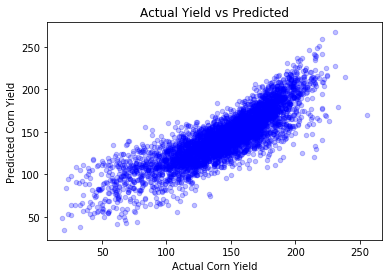

In [101]:
plt.scatter(labels_test, regr.predict(data_test), c = 'b', s = 20, alpha = 0.25)
plt.title("Actual Yield vs Predicted")
plt.ylabel("Predicted Corn Yield")
plt.xlabel("Actual Corn Yield")

Text(0.5,0,'Fitted values')

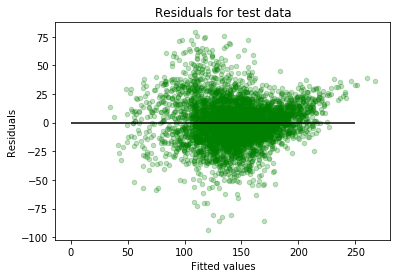

In [102]:
plt.scatter(regr.predict(data_test), regr.predict(data_test) -labels_test, c = 'g', s = 20, alpha = 0.25)
plt.hlines(y=0,xmin=0, xmax = 250)
plt.title("Residuals for test data")
plt.ylabel("Residuals")
plt.xlabel("Fitted values")

Ideally I would also want to run a few additional tests to assess the model validity. While creating these additional plots is very straight forward in R, I've hit a bit of a snag with Python (see next few cells for more info.). The additional plots would include a QQ plot to see if it follows a normal distribution (values are not too far from the diagonal), a scale-location plot which compares the standardized residuals with the fitted values and allows you to check for homoscedasticity, and a leverage plot to check for outliers that have too much influence on the model.

Reference for future enhancement: https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034; https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html

#### Attempt 1 at the Q-plot

In [261]:
def residuals(clf, X, y, r_type='standardized'):
    """Calculate residuals or standardized residuals.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    r_type : str
        Type of residuals to return: 'raw', 'standardized', 'studentized'.
        Defaults to 'standardized'.

        * 'raw' will return the raw residuals.
        * 'standardized' will return the standardized residuals, also known as
          internally studentized residuals, which is calculated as the residuals
          divided by the square root of MSE (or the STD of the residuals).
        * 'studentized' will return the externally studentized residuals, which
          is calculated as the raw residuals divided by sqrt(LOO-MSE * (1 -
          leverage_score)).

    Returns
    -------
    numpy.ndarray
        An array of residuals.
        
        https://regressors.readthedocs.io/en/latest/_modules/regressors/stats.html
        https://stackoverflow.com/questions/47838306/getting-no-loop-matching-the-specified-signature-and-casting-error
    """
    # Make sure value of parameter 'r_type' is one we recognize
    assert r_type in ('raw', 'standardized', 'studentized'), (
        "Invalid option for 'r_type': {0}".format(r_type))
    y_true = y.astype(dtype='float')
    # Use classifier to make predictions
    y_pred = clf.predict(X)
    # Make sure dimensions agree (Numpy still allows subtraction if they don't)
    assert y_true.shape == y_pred.shape, (
        "Dimensions of y_true {0} do not match y_pred {1}".format(y_true.shape,
                                                                  y_pred.shape))
    # Get raw residuals, or standardized or standardized residuals
    resids = y_pred - y_true
    if r_type == 'standardized':
        resids = resids / np.std(resids)
    elif r_type == 'studentized':
        # Prepare a blank array to hold studentized residuals
        studentized_resids = np.zeros(y_true.shape[0], dtype='float')
        # Calcluate hat matrix of X values so you can get leverage scores
        hat_matrix = np.dot(
            np.dot(X, np.linalg.inv(np.dot(np.transpose(X), X))),
            np.transpose(X))
        # For each point, calculate studentized residuals w/ leave-one-out MSE
        for i in range(y_true.shape[0]):
            # Make a mask so you can calculate leave-one-out MSE
            mask = np.ones(y_true.shape[0], dtype='bool')
            mask[i] = 0
            loo_mse = np.average(resids[mask] ** 2, axis=0)  # Leave-one-out MSE
            # Calculate studentized residuals
            studentized_resids[i] = resids[i] / np.sqrt(
                loo_mse * (1 - hat_matrix[i, i]))
        resids = studentized_resids
    return resids
model_norm_residuals = residuals(regr, data_test, labels_test,  r_type='studentized')

TypeError: No loop matching the specified signature and casting
was found for ufunc inv

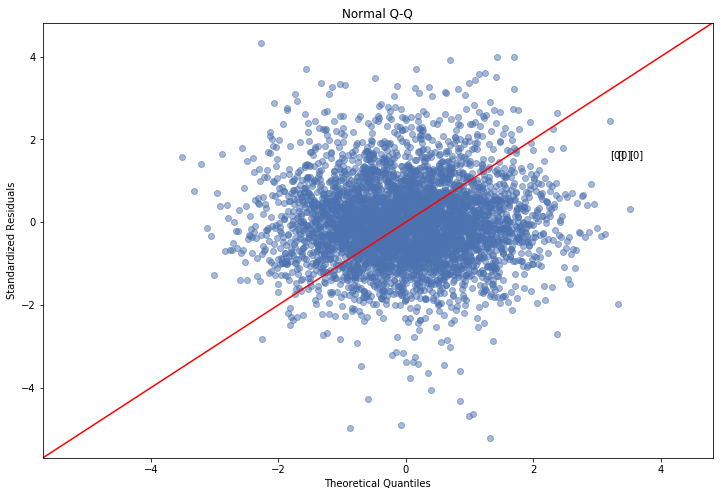

In [225]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

#### Attempt 2 at the Q-plot

In [ ]:
import statsmodels.formula.api as smf

Rather than trying to calc all the pieces for the graphs mannually, many people seem to use the statsmodels package. This OLS model looks much more like the R implementation; however, Python seems to be struggling with the pieces of the variable names that are reserved words in the python language (mod, max, min etc...). It looks like there is a package called patsy that can help handle this issue (https://www.statsmodels.org/stable/example_formulas.html; https://patsy.readthedocs.io/en/v0.2.1/builtins-reference.html#patsy.builtins.Q; https://github.com/statsmodels/statsmodels/issues/1441/), but I've spent too much time on this bug so I'm going to leave it as a next step.

In [275]:
fml = " yield ~ met_avg_t + met_evi + met_extreme_cold + met_extreme_hot1 + met_gdd + met_max_avg_rh + met_max_avg_t + met_max_rh + met_max_t + met_max_vpd + met_min__avg_rh + met_min_avg_t + met_min_rh + met_min_t + met_p_mm + met_sh + met_sr_wm2 " 
#+ mod_lst_day + mod_lst_night + mod_nbar_1 + mod_nbar_2 + mod_nbar_3 + mod_nbar_4 + mod_nbar_5 + mod_nbar_6 + mod_nbar_7 + 'mod_ndvi' + 'phen_dor' + 'phen_gup'"
fml

' yield ~ met_avg_t + met_evi + met_extreme_cold + met_extreme_hot1 + met_gdd + met_max_avg_rh + met_max_avg_t + met_max_rh + met_max_t + met_max_vpd + met_min__avg_rh + met_min_avg_t + met_min_rh + met_min_t + met_p_mm + met_sh + met_sr_wm2 '

In [276]:
ols_data = df_03to17_annual[df_03to17_annual['year']!=2018]
ols_data = ols_data .drop('area_harvested_obs', axis = 1)
ols_data = ols_data .drop('adm2_code', axis = 1)
ols_data  = ols_data .drop('adm1_code', axis = 1)

#in the SM package the data needs to be combined (data + labels) in a single dataframe, so its a departure from the streamlined approach for constructing a bunch of models at once 

import statsmodels.formula.api as smf
ols_data = ols_data .drop('year', axis = 1)
#old_regr = sm.OLS.from_formula('yield ~ ' + ' + '.join(ols_data.columns.difference(['yield'])), ols_data)
ols_regr = smf.ols(formula = fml, data = ols_data)
result = old_regr.fit()

PatsyError: Error evaluating factor: SyntaxError: unexpected EOF while parsing (<string>, line 1)
    yield ~ met_avg_t + met_evi + met_extreme_cold + met_extreme_hot1 + met_gdd + met_max_avg_rh + met_max_avg_t + met_max_rh + met_max_t + met_max_vpd + met_min__avg_rh + met_min_avg_t + met_min_rh + met_min_t + met_p_mm + met_sh + met_sr_wm2
    ^^^^^

In [259]:
ols_data.head()

,yield,phen_gup,phen_dor,met_avg_t,met_extreme_cold,met_extreme_hot1,met_gdd,met_max_rh,met_max_t,met_max_avg_rh,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
0,123.0,72,295,68.588082,45,0,3464.206752,100.0,95.432,94.184421,...,81.775770,56.781858,0.094530,0.318926,0.044129,0.087745,0.360954,0.290754,0.171229,0.537097
1,111.0,72,295,68.745890,37,3,3484.853876,100.0,100.922,93.969739,...,82.371003,56.705666,0.092474,0.315844,0.043941,0.086288,0.356350,0.289552,0.169410,0.541999
2,127.0,72,295,68.805068,38,1,3457.722264,100.0,98.600,94.242992,...,81.450290,57.265342,0.091726,0.314565,0.042958,0.084878,0.355302,0.285262,0.166464,0.539956
3,85.0,72,295,69.963973,33,37,3554.026852,100.0,102.812,93.804784,...,86.370751,56.874471,0.102669,0.319451,0.048599,0.093401,0.361230,0.299292,0.190276,0.509969
4,73.0,72,295,70.033014,35,29,3583.245157,100.0,105.242,91.662996,...,85.217074,57.322055,0.094963,0.311940,0.044385,0.086954,0.356378,0.291818,0.176689,0.529163


### Exporting validation predictions

In [103]:
labels_val = regr.predict(data_validation)
labels_val

array([123.647, 130.461, 132.993, ..., 106.611, 153.925, 138.288])

In [104]:
np.savetxt("validation_predictions_2018-county-corn_yield2.csv", labels_val, delimiter=",", fmt ='%10.5f')

<a id='section5'></a>
## Section 5 - Presenting your results

See ppt (?)